In [1]:
%%capture
!pip install wandb -qU

In [2]:
# Log in to your W&B account
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
import os
from google.colab import drive

if not os.path.exists('/content/gdrive'):
  drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
config  = {
    'epochs': 5,
    'batch_size': 4,
    'num_filter' : [16, 32, 32],
    'weight_decay': 0.0005,
    'learning_rate': 1e-3,
    'seed': 42
    }

In [5]:
wandb.init(project='CNN_MRI', config=config)
wandb.run.name = '20241201' ## Run name
wandb.run.save()
config = wandb.config

wandb: Currently logged in as: dlsgml107 (dlsgml107-spidercore). Use `wandb login --relogin` to force relogin


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


# 1. Preprocessing

### 데이터 불러오기

In [6]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [7]:
df= pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/SMWU/2024/merge_prep.csv')
df

,PTID,BAT126,HMT10,HMT100,HMT102,HMT11,HMT12,HMT13,HMT15,HMT16,...,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,AV45_bl
0,002_S_0295,194.0,0.52,31.0,33.0,0.17,0.03,182.0,66.6,23.2,...,NaN,NaN,NaN,NaN,NaN,888.1,355.2,34.73,NaN,NaN
1,002_S_0413,433.0,0.23,30.0,33.0,0.18,0.02,155.0,53.5,34.5,...,NaN,NaN,NaN,NaN,NaN,1006.0,107.3,10.57,NaN,NaN
2,002_S_0559,452.0,0.42,30.0,33.0,0.26,0.03,156.0,71.2,20.0,...,NaN,NaN,NaN,NaN,NaN,1245.0,188.6,15.82,NaN,NaN
3,002_S_0619,642.0,0.21,33.0,32.0,0.19,0.05,228.0,66.1,25.6,...,NaN,NaN,NaN,NaN,NaN,393.8,212.4,18.56,NaN,NaN
4,002_S_0685,322.0,0.39,30.0,33.0,0.19,0.08,357.0,62.8,27.4,...,NaN,NaN,NaN,NaN,NaN,1700.0,265.9,22.82,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,941_S_4376,525.0,0.21,31.0,32.0,0.12,0.09,209.0,54.8,35.3,...,1.00000,1.0,1.00000,1.0,1.00000,1700.0,277.0,23.97,1.303080,0.9419
1596,941_S_4377,256.0,0.59,30.0,34.0,0.11,0.04,262.0,51.6,37.2,...,2.00000,2.2,2.00000,2.5,2.15385,1349.0,312.6,26.47,1.392690,1.1362
1597,941_S_4420,747.0,0.50,31.0,33.0,0.07,0.02,180.0,60.9,26.4,...,1.00000,1.0,1.50000,NaN,1.41935,795.0,339.4,32.22,1.229150,1.3555
1598,941_S_4764,454.0,0.40,32.0,35.0,0.15,0.05,250.0,55.7,32.7,...,1.14286,1.4,1.20000,1.5,1.23684,912.4,295.5,27.57,1.340120,1.2638


압축해제 하지 않고 이미지 불러오기

In [8]:
import tarfile
import numpy as np
from PIL import Image
import io

In [9]:
tar_path = '/content/gdrive/MyDrive/Colab Notebooks/SMWU/2024/Image Dataset/ADNI_1Y_15T.tar'
tar = tarfile.open(tar_path, mode='r')

In [10]:
# tar.getnames()

In [11]:
# tar.getmembers()

In [12]:
images = []
labels = []
img_PTID = []
no_labels = []

# .tar 파일 열기
with tarfile.open(tar_path, "r") as tar:
    for member in tqdm(tar.getmembers()):

        # .jpg 파일만 처리
        if member.isfile() and member.name.lower().endswith('.jpg'):
            try:
                # tar 파일 내의 이미지 데이터를 읽어 메모리에 로드
                file_obj = tar.extractfile(member)
                if file_obj is not None:
                    PT_ID = member.name.split('/')[1]
                    if PT_ID in df['PTID'].values:
                        labels.append(df[df['PTID']==PT_ID]['DX_bl'].values[0])
                        image = Image.open(io.BytesIO(file_obj.read()))
                        images.append(image)
                        img_PTID.append(PT_ID)
                        # print(f"Loaded image: {member.name}")
                    else:
                        no_labels.append(PT_ID)


            except Exception as e:
                print(f"Failed to load image {member.name}: {e}")



100%|██████████| 13420/13420 [00:11<00:00, 1217.82it/s]


In [13]:
print(len(images))
print(len(labels))
print(len(no_labels))

12480
12480
300


In [14]:
set(no_labels)

{'012_S_0712',
 '013_S_1205',
 '023_S_0030',
 '023_S_0083',
 '027_S_0644',
 '027_S_1385',
 '027_S_1387',
 '041_S_1423',
 '067_S_0056',
 '098_S_0149',
 '098_S_0160',
 '123_S_0162',
 '137_S_0459',
 '137_S_0631',
 '141_S_0853'}

In [70]:
images[0].shape ### MRI Image는 192x192 사이즈에 채널이 3채널입니다.

torch.Size([3, 192, 192])

In [15]:
PTID_list = set(img_PTID)
print(len(PTID_list))

624


In [16]:
df_exist = df[df['PTID'].isin(PTID_list)]
df_exist

,PTID,BAT126,HMT10,HMT100,HMT102,HMT11,HMT12,HMT13,HMT15,HMT16,...,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,AV45_bl
0,002_S_0295,194.0,0.52,31.0,33.0,0.17,0.03,182.0,66.6,23.2,...,NaN,NaN,NaN,NaN,NaN,888.1,355.2,34.73,NaN,NaN
1,002_S_0413,433.0,0.23,30.0,33.0,0.18,0.02,155.0,53.5,34.5,...,NaN,NaN,NaN,NaN,NaN,1006.0,107.3,10.57,NaN,NaN
3,002_S_0619,642.0,0.21,33.0,32.0,0.19,0.05,228.0,66.1,25.6,...,NaN,NaN,NaN,NaN,NaN,393.8,212.4,18.56,NaN,NaN
4,002_S_0685,322.0,0.39,30.0,33.0,0.19,0.08,357.0,62.8,27.4,...,NaN,NaN,NaN,NaN,NaN,1700.0,265.9,22.82,NaN,NaN
5,002_S_0729,2514.0,0.34,29.0,34.0,0.10,0.05,231.0,68.5,22.0,...,NaN,NaN,NaN,NaN,NaN,957.8,316.9,31.69,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,141_S_1255,NaN,0.24,31.0,34.0,0.11,0.03,232.0,76.3,18.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1579,941_S_1194,313.0,0.33,36.0,34.0,0.73,0.03,137.0,58.4,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.23091,NaN
1581,941_S_1197,275.0,0.46,32.0,33.0,0.15,0.10,218.0,56.0,34.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.40130,NaN
1582,941_S_1202,265.0,0.40,34.0,36.0,0.13,0.06,159.0,63.7,26.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.14353,NaN


### 문자형 레이블을 categorical number로 변환

In [17]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_exist['DX_bl'] = le.fit_transform(df_exist['DX_bl'])
df_exist['DX_bl']

<ipython-input-17-a8d46b9bb90e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_exist['DX_bl'] = le.fit_transform(df_exist['DX_bl'])


,DX_bl
0,1
1,1
3,0
4,1
5,2
...,...
1551,2
1579,1
1581,1
1582,1


In [18]:
print(list(le.classes_))
print(le.transform(list(le.classes_)))

['AD', 'CN', 'LMCI']
[0 1 2]


In [19]:
df_exist['DX_bl'].value_counts()

,count
DX_bl,
2,305
1,193
0,126


결측값 처리

In [20]:
df_exist.isna().sum(axis=0) ## Column별로 결측값의 개수를 파악

,0
PTID,0
BAT126,12
HMT10,12
HMT100,12
HMT102,12
...,...
ABETA_bl,296
TAU_bl,296
PTAU_bl,296
FDG_bl,320


<Axes: >

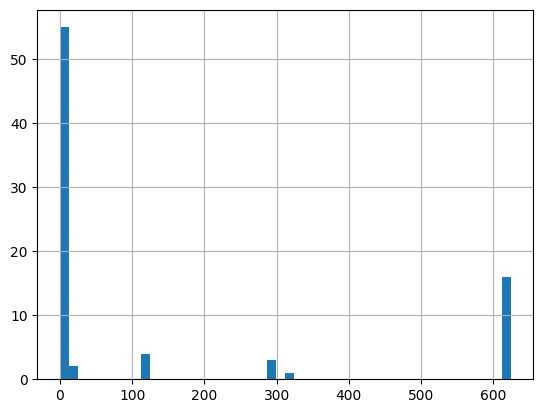

In [21]:
df_na = df_exist.isna().sum(axis=0)
df_na.hist(bins=50)

결측값 처리 1. 그냥 다 0으로 채운다

In [22]:
df_fillna = df_exist.fillna(0)
df_fillna

,PTID,BAT126,HMT10,HMT100,HMT102,HMT11,HMT12,HMT13,HMT15,HMT16,...,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl,AV45_bl
0,002_S_0295,194.0,0.52,31.0,33.0,0.17,0.03,182.0,66.6,23.2,...,0.0,0.0,0.0,0.0,0.0,888.1,355.2,34.73,0.00000,0.0
1,002_S_0413,433.0,0.23,30.0,33.0,0.18,0.02,155.0,53.5,34.5,...,0.0,0.0,0.0,0.0,0.0,1006.0,107.3,10.57,0.00000,0.0
3,002_S_0619,642.0,0.21,33.0,32.0,0.19,0.05,228.0,66.1,25.6,...,0.0,0.0,0.0,0.0,0.0,393.8,212.4,18.56,0.00000,0.0
4,002_S_0685,322.0,0.39,30.0,33.0,0.19,0.08,357.0,62.8,27.4,...,0.0,0.0,0.0,0.0,0.0,1700.0,265.9,22.82,0.00000,0.0
5,002_S_0729,2514.0,0.34,29.0,34.0,0.10,0.05,231.0,68.5,22.0,...,0.0,0.0,0.0,0.0,0.0,957.8,316.9,31.69,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,141_S_1255,0.0,0.24,31.0,34.0,0.11,0.03,232.0,76.3,18.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00000,0.0
1579,941_S_1194,313.0,0.33,36.0,34.0,0.73,0.03,137.0,58.4,20.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.23091,0.0
1581,941_S_1197,275.0,0.46,32.0,33.0,0.15,0.10,218.0,56.0,34.4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.40130,0.0
1582,941_S_1202,265.0,0.40,34.0,36.0,0.13,0.06,159.0,63.7,26.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,1.14353,0.0


결측값 처리 2. 칼럼별로 개수를 세서 500개 이상 비어있는 column은 삭제 후 0으로 채우기

In [23]:
null_dict = dict(df_exist.isnull().sum())
null_dict_sort = sorted(null_dict.items(), key=lambda x: x[1])
null_dict_sort

[('PTID', 0),
 ('DX_bl', 0),
 ('APOE4', 0),
 ('CDRSB_bl', 0),
 ('ADAS11_bl', 0),
 ('ADASQ4_bl', 0),
 ('MMSE_bl', 0),
 ('LDELTOTAL_BL', 0),
 ('mPACCdigit_bl', 0),
 ('mPACCtrailsB_bl', 0),
 ('ICV_bl', 0),
 ('RCT12', 3),
 ('RCT1407', 3),
 ('RCT183', 3),
 ('RCT19', 3),
 ('RCT20', 3),
 ('RCT3', 3),
 ('RCT392', 3),
 ('RCT6', 3),
 ('RCT8', 3),
 ('RCT9', 3),
 ('RAVLT_immediate_bl', 3),
 ('RAVLT_learning_bl', 3),
 ('RAVLT_forgetting_bl', 3),
 ('FAQ_bl', 3),
 ('ADAS13_bl', 4),
 ('RAVLT_perc_forgetting_bl', 5),
 ('RCT1', 6),
 ('RCT11', 6),
 ('RCT13', 6),
 ('RCT14', 6),
 ('RCT4', 6),
 ('TRABSCOR_bl', 6),
 ('WholeBrain_bl', 7),
 ('Ventricles_bl', 11),
 ('BAT126', 12),
 ('HMT10', 12),
 ('HMT100', 12),
 ('HMT102', 12),
 ('HMT11', 12),
 ('HMT12', 12),
 ('HMT15', 12),
 ('HMT16', 12),
 ('HMT17', 12),
 ('HMT18', 12),
 ('HMT19', 12),
 ('HMT2', 12),
 ('HMT3', 12),
 ('HMT4', 12),
 ('HMT40', 12),
 ('HMT7', 12),
 ('HMT8', 12),
 ('HMT9', 12),
 ('RCT29', 12),
 ('RCT5', 12),
 ('RCT1408', 15),
 ('HMT13', 22),
 ('

In [24]:
null_cols = [k for k,v in null_dict.items() if v >500] ##
null_cols

['MOCA_bl',
 'EcogPtMem_bl',
 'EcogPtLang_bl',
 'EcogPtVisspat_bl',
 'EcogPtPlan_bl',
 'EcogPtOrgan_bl',
 'EcogPtDivatt_bl',
 'EcogPtTotal_bl',
 'EcogSPMem_bl',
 'EcogSPLang_bl',
 'EcogSPVisspat_bl',
 'EcogSPPlan_bl',
 'EcogSPOrgan_bl',
 'EcogSPDivatt_bl',
 'EcogSPTotal_bl',
 'AV45_bl']

In [25]:
df_drop1 = df_exist.drop(null_cols, axis=1)
df_drop1

,PTID,BAT126,HMT10,HMT100,HMT102,HMT11,HMT12,HMT13,HMT15,HMT16,...,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl
0,002_S_0295,194.0,0.52,31.0,33.0,0.17,0.03,182.0,66.6,23.2,...,7068.0,1076350.0,3619.0,16561.0,19829.0,1633860.0,888.1,355.2,34.73,NaN
1,002_S_0413,433.0,0.23,30.0,33.0,0.18,0.02,155.0,53.5,34.5,...,6905.0,1052840.0,4133.0,20208.0,20341.0,1599490.0,1006.0,107.3,10.57,NaN
3,002_S_0619,642.0,0.21,33.0,32.0,0.19,0.05,228.0,66.1,25.6,...,5812.0,1075140.0,2773.0,20675.0,19959.0,2057400.0,393.8,212.4,18.56,NaN
4,002_S_0685,322.0,0.39,30.0,33.0,0.19,0.08,357.0,62.8,27.4,...,7194.0,989449.0,4201.0,13629.0,18673.0,1529390.0,1700.0,265.9,22.82,NaN
5,002_S_0729,2514.0,0.34,29.0,34.0,0.10,0.05,231.0,68.5,22.0,...,6107.0,927913.0,2511.0,18072.0,17213.0,1291140.0,957.8,316.9,31.69,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,141_S_1255,NaN,0.24,31.0,34.0,0.11,0.03,232.0,76.3,18.4,...,5732.0,795001.0,3532.0,15089.0,14353.0,1281940.0,NaN,NaN,NaN,NaN
1579,941_S_1194,313.0,0.33,36.0,34.0,0.73,0.03,137.0,58.4,20.7,...,6169.0,983626.0,4187.0,14703.0,17937.0,1728400.0,NaN,NaN,NaN,1.23091
1581,941_S_1197,275.0,0.46,32.0,33.0,0.15,0.10,218.0,56.0,34.4,...,6410.0,887612.0,3903.0,17777.0,15523.0,1409010.0,NaN,NaN,NaN,1.40130
1582,941_S_1202,265.0,0.40,34.0,36.0,0.13,0.06,159.0,63.7,26.1,...,5743.0,1052020.0,2398.0,18309.0,21014.0,1695690.0,NaN,NaN,NaN,1.14353


In [26]:
df_fillna2 = df_drop1.fillna(0)
df_fillna2

,PTID,BAT126,HMT10,HMT100,HMT102,HMT11,HMT12,HMT13,HMT15,HMT16,...,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,ABETA_bl,TAU_bl,PTAU_bl,FDG_bl
0,002_S_0295,194.0,0.52,31.0,33.0,0.17,0.03,182.0,66.6,23.2,...,7068.0,1076350.0,3619.0,16561.0,19829.0,1633860.0,888.1,355.2,34.73,0.00000
1,002_S_0413,433.0,0.23,30.0,33.0,0.18,0.02,155.0,53.5,34.5,...,6905.0,1052840.0,4133.0,20208.0,20341.0,1599490.0,1006.0,107.3,10.57,0.00000
3,002_S_0619,642.0,0.21,33.0,32.0,0.19,0.05,228.0,66.1,25.6,...,5812.0,1075140.0,2773.0,20675.0,19959.0,2057400.0,393.8,212.4,18.56,0.00000
4,002_S_0685,322.0,0.39,30.0,33.0,0.19,0.08,357.0,62.8,27.4,...,7194.0,989449.0,4201.0,13629.0,18673.0,1529390.0,1700.0,265.9,22.82,0.00000
5,002_S_0729,2514.0,0.34,29.0,34.0,0.10,0.05,231.0,68.5,22.0,...,6107.0,927913.0,2511.0,18072.0,17213.0,1291140.0,957.8,316.9,31.69,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1551,141_S_1255,0.0,0.24,31.0,34.0,0.11,0.03,232.0,76.3,18.4,...,5732.0,795001.0,3532.0,15089.0,14353.0,1281940.0,0.0,0.0,0.00,0.00000
1579,941_S_1194,313.0,0.33,36.0,34.0,0.73,0.03,137.0,58.4,20.7,...,6169.0,983626.0,4187.0,14703.0,17937.0,1728400.0,0.0,0.0,0.00,1.23091
1581,941_S_1197,275.0,0.46,32.0,33.0,0.15,0.10,218.0,56.0,34.4,...,6410.0,887612.0,3903.0,17777.0,15523.0,1409010.0,0.0,0.0,0.00,1.40130
1582,941_S_1202,265.0,0.40,34.0,36.0,0.13,0.06,159.0,63.7,26.1,...,5743.0,1052020.0,2398.0,18309.0,21014.0,1695690.0,0.0,0.0,0.00,1.14353


### 이미지 전처리

In [27]:
from collections import Counter

img_size = []
for img in images:
    img_size.append(img.size)

result = Counter(img_size)
print(result)

Counter({(256, 256): 7660, (192, 192): 4820})


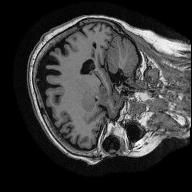

In [28]:
images[0]

In [29]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

In [30]:
img_tensors = []

transform = transforms.Compose([
        transforms.Resize((192,192)),  # 이미지 크기 조정
        transforms.ToTensor(),         # 텐서로 변환
        # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 정규화
    ])

for img in tqdm(images):
    img_tensor = transform(img)
    img_tensors.append(img_tensor)

100%|██████████| 12480/12480 [00:22<00:00, 564.46it/s]


In [31]:
print(len(img_tensors))
# print(len(labels_enc))

12480


# 2. Dataset Split

환자별로 20장의 데이터가 주어졌는데 이 20장의 이미지가 거의 비슷하기 때문에 환자를 무시하고 전부 랜덤으로 나누면 너무 쉬운 task가 됩니다. 그래서 1번 환자는 train, 2번 환자는 test... 처럼 환자를 기준으로 train-validation-test를 구분하겠습니다.

In [32]:
from sklearn.model_selection import train_test_split

train_val_ID, test_ID = train_test_split(list(set(img_PTID)), test_size=0.1, random_state=15)

train_ID, val_ID = train_test_split(train_val_ID, test_size=0.1, random_state=15)

print('# of train_set : %.0f, # of train_set : %.0f, # of test_set : %.0f' %(len(train_ID), len(val_ID), len(test_ID)))

# of train_set : 504, # of train_set : 57, # of test_set : 63


lab data는 scale을 맞춰줘야 합니다

In [33]:
df_train_pre = df_fillna2[df_fillna2['PTID'].isin(train_ID)]
df_val_pre = df_fillna2[df_fillna2['PTID'].isin(val_ID)]
df_test_pre = df_fillna2[df_fillna2['PTID'].isin(test_ID)]

In [34]:
cols_X = list(df_fillna2.columns)
cols_X.remove('DX_bl')
cols_X.remove('PTID')
len(cols_X)

63

In [35]:
df_train_pre_X = df_train_pre[cols_X]
df_val_pre_X = df_val_pre[cols_X]
df_test_pre_X = df_test_pre[cols_X]

In [36]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_scaler = StandardScaler()
df_tr_X_scaled = X_scaler.fit_transform(df_train_pre_X)
df_val_X_scaled = X_scaler.transform(df_val_pre_X)
df_test_X_scaled = X_scaler.transform(df_test_pre_X)

df_tr_X_scaled

array([[-0.98895602,  0.93924871,  0.43698767, ...,  1.18841521,
         1.13578854, -0.9448071 ],
       [-0.21488483, -1.08538947,  0.20660923, ..., -0.26973724,
        -0.25580362, -0.9448071 ],
       [ 0.46202262, -1.22501969,  0.89774455, ...,  0.34846293,
         0.2044125 , -0.9448071 ],
       ...,
       [-0.7266139 ,  0.52035805,  0.66736611, ..., -0.90087786,
        -0.86462519,  1.44840911],
       [-0.75900182,  0.1014674 ,  1.12812299, ..., -0.90087786,
        -0.86462519,  1.00817551],
       [ 0.21587446,  0.38072784,  0.43698767, ..., -0.90087786,
        -0.86462519,  1.04255462]])

scaling된 값들을 다시 dataframe으로 복원

In [37]:
df_train_post = pd.DataFrame(df_tr_X_scaled, columns=cols_X, index=df_train_pre.index)
df_train_post['PTID'] = df_train_pre['PTID']
df_train_post['DX_bl'] = df_train_pre['DX_bl']

df_val_post = pd.DataFrame(df_val_X_scaled, columns=cols_X, index=df_val_pre.index)
df_val_post['PTID'] = df_val_pre['PTID']
df_val_post['DX_bl'] = df_val_pre['DX_bl']

df_test_post = pd.DataFrame(df_test_X_scaled, columns=cols_X, index=df_test_pre.index)
df_test_post['PTID'] = df_test_pre['PTID']
df_test_post['DX_bl'] = df_test_pre['DX_bl']

In [38]:
img_train_X = []
df_train_X = []
train_Y = []
img_val_X = []
df_val_X = []
val_Y = []
img_test_X = []
df_test_X = []
test_Y = []

for idx, id in tqdm(enumerate(img_PTID)):
    if id in train_ID:
        img_train_X.append(img_tensors[idx])
        df_train_X.append(df_train_post[df_train_post['PTID']== id][cols_X].values[0])
        train_Y.append(df_train_post[df_train_post['PTID']== id]['DX_bl'].values[0])

    elif id in val_ID:
        img_val_X.append(img_tensors[idx])
        df_val_X.append(df_val_post[df_val_post['PTID']== id][cols_X].values[0])
        val_Y.append(df_val_post[df_val_post['PTID']== id]['DX_bl'].values[0])

    elif id in test_ID:
        img_test_X.append(img_tensors[idx])
        df_test_X.append(df_test_post[df_test_post['PTID']== id][cols_X].values[0])
        test_Y.append(df_test_post[df_test_post['PTID']== id]['DX_bl'].values[0])
    else:
        print('{} error!!'.f(id))

12480it [00:17, 715.06it/s]


In [39]:
tr_Y_valued = np.array(train_Y).reshape(-1,1)
val_Y_valued = np.array(val_Y).reshape(-1,1)
test_Y_valued = np.array(test_Y).reshape(-1,1)

tr_Y_valued

array([[2],
       [2],
       [2],
       ...,
       [2],
       [2],
       [2]])

# 3. Model Training

In [40]:
import torch.nn as nn

In [41]:
import random

torch.manual_seed(config.seed)
random.seed(config.seed)
np.random.seed(config.seed)

In [42]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


### DataLoader

In [43]:
# Creating the dataset class
class CustomDataset(Dataset):
    # Constructor
    def __init__(self, img_x, df_x, y): ### (self는 무시하고) 데이터 보따리에 함수 순서 맞춰서 데이터 가져옴
        self.img_x_data = img_x
        self.df_x_data = df_x
        self.y_data = y

    # getting data length
    def __len__(self): ### (self는 무시하고) 데이터 보따리 안에 있는 총 데이터 개수 카운트
        return len(self.y_data)

    # Getter
    def __getitem__(self, idx): ### (self는 무시하고) 데이터 보따리 안에 있는 데이터에 순서대로 index 붙여서 꺼내옴.
        # return torch.FloatTensor(self.x_data[idx]), torch.FloatTensor(self.y_data[idx])
        return torch.FloatTensor(self.img_x_data[idx]), torch.FloatTensor(self.df_x_data[idx]), torch.LongTensor(self.y_data[idx]) ### 위에꺼 에러나서 디버깅하다보니 되는걸로 변경

In [44]:
tr_dataset = CustomDataset(img_train_X, df_train_X, tr_Y_valued)
tr_dataloader = DataLoader(tr_dataset, batch_size=16, shuffle=True)

val_dataset = CustomDataset(img_val_X, df_val_X, val_Y_valued)
val_dataloader = DataLoader(val_dataset, batch_size=len(val_Y_valued), shuffle=False)

test_dataset = CustomDataset(img_test_X, df_test_X, test_Y_valued)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_Y_valued), shuffle=False)

In [45]:
loader_iter = iter(tr_dataloader)
img,df,y = next(loader_iter)
print(img)
print(df)
print(y)

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0

In [46]:
# import matplotlib.pyplot as plt
# imgs = torchvision.utils.make_grid(img, nrow=4)
# np_img = imgs.numpy()
# plt.imshow(np.transpose(np_img, (1,2,0)))

label :  tensor([2])
df :  tensor([-0.0886, -0.3872, -0.2541,  0.1439,  1.0835,  0.3557,  0.4255, -0.0516,
         0.1270, -0.5384,  1.1311,  0.4903,  1.6033,  2.0888, -0.3434,  1.5511,
         0.2018,  0.0573,  0.2673, -0.5192,  0.1434,  0.2340,  0.1363,  0.4756,
        -0.2606, -0.0024,  0.4361,  0.5079, -0.1174, -0.5902,  0.9253,  1.2081,
         1.1406,  1.0157,  0.2920,  0.9059, -0.4089,  2.0891, -0.4109,  0.4755,
         0.1425, -0.2708,  0.0478, -0.5641, -0.2355,  0.7172,  1.0617,  0.4093,
        -0.7314,  0.0147,  0.3883,  0.3937, -0.5481,  0.7680,  1.7169,  0.3614,
         0.8458,  0.8236,  1.1371,  0.4113,  1.6525,  1.9082,  1.3800])


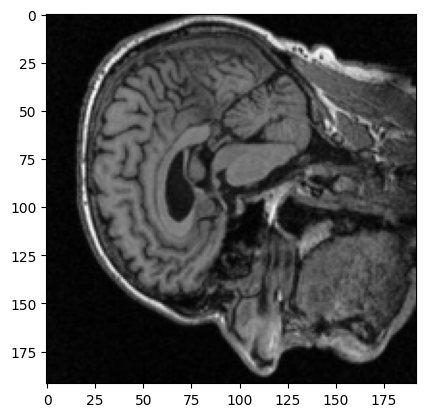

In [47]:
import matplotlib.pyplot as plt
img, df, y = next(iter(val_dataloader))

idx = 3

plt.imshow(img[idx, 0, :, :], 'gray')
print('label : ', y[idx])
print('df : ', df[idx])
plt.show()

### Model Setting

torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)

In [63]:
class MultiNet(nn.Module):
    def __init__(self):
        super(MultiNet, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, config.num_filter[0], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) ## 96x96
            )

        self.layer2 = nn.Sequential(
            nn.Conv2d(config.num_filter[0], config.num_filter[1], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) ## 48x48
            )

        self.layer3 = nn.Sequential(
            nn.Conv2d(config.num_filter[1], config.num_filter[2], kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2) ## 24x24
            )

        self.fc1 = nn.Linear(24 * 24 * 32, 1000)


        self.lab_data = nn.Sequential(
            nn.Linear(63, 40),  ### input size = 79
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
        )

        self.fc2 = nn.Linear(1020, 3)


    def forward(self, img, df):
        img_out = self.layer1(img)
        img_out = self.layer2(img_out)
        img_out = self.layer3(img_out)
        img_out = img_out.reshape(img_out.size(0), -1) ## Vectorize, Flatten
        img_out = self.fc1(img_out)

        df_out = self.lab_data(df)

        out = torch.cat((img_out, df_out), dim=1)

        out = self.fc2(out)
        return out

In [64]:
model = MultiNet().to(device)
print(model)

MultiNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=18432, out_features=1000, bias=True)
  (lab_data): Sequential(
    (0): Linear(in_features=63, out_features=40, bias=True)
    (1): ReLU()
    (2): Linear(in_features=40, out_features=20, bias=True)
    (3): ReLU()
  )
  (fc2): Linear(in_features=1020, out_features=3, bias=True)
)


CNN 부분에 Resnet 쓰는 모델

In [50]:
from torchvision import models

model_resnet = models.resnet18(pretrained=False)

# change input layer
# the default number of input channel in the resnet is 3, but our images are 1 channel. So we have to change 3 to 1.
# nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False) <- default
# model_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

# change fc layer
num_ftrs = model_resnet.fc.in_features ## 512 (fc): Linear(in_features=512, out_features=50, bias=True)
model_resnet.fc = nn.Linear(num_ftrs, 50)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [51]:
class MultiNet_with_model(nn.Module):
    def __init__(self):
        super(MultiNet_with_model, self).__init__()

        # resnet = model_resnet
        # self.resnet = nn.Sequential(*list(resnet.children())) ### initialze

        self.resnet = model_resnet

        self.lab_data = nn.Sequential(
            nn.Linear(63, 40),  ### input size = 79
            nn.ReLU(),
            nn.Linear(40, 20),
            nn.ReLU(),
        )

        self.fc2 = nn.Linear(70, 3)


    def forward(self, img, df):
        resnet_out = self.resnet(img)

        df_out = self.lab_data(df)

        out = torch.cat((resnet_out, df_out), dim=1)

        out = self.fc2(out)
        return out

In [52]:
model = MultiNet_with_model().to(device)
print(model)

MultiNet_with_model(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True

### Optimizer

In [53]:
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

### Loss Function

In [54]:
loss_f = nn.CrossEntropyLoss(reduction='sum')
loss_f_batch = nn.CrossEntropyLoss(reduction='none')

In [55]:
##  log: ['gradients', 'parameters', 'all']
## log_freq	: N 배치마다 그레이디언트와 파라미터를 로그

wandb.watch(model, loss_f, log="all", log_freq=10)

### Model Training

In [65]:
tr_losses = []
val_losses = []
for epoch in range(1, config.epochs):
    model.train() ### Train mode로 변경
    batch_loss = 0
    tqdm_loader = tqdm(tr_dataloader) ## progressing bar
    for batch_idx, samples in enumerate(tqdm_loader): ### 다음 batch 가져옴
        images, df, labels = samples
        images = images.to(device) ### GPU에 올림
        df = df.to(device)
        labels = labels.to(device)

        logit = model(images, df) ### forward() 실행 -> feed forward!!

        tr_loss = loss_f(logit, labels.squeeze(-1)) ### loss 계산
        optimizer.zero_grad() ### 이전에 계산했던 gradient들 초기화 (누적되면 안됨)
        tr_loss.backward() ### gradient계산 및 back propagation
        optimizer.step() #### update

        tr_loss_batch = loss_f_batch(logit, labels.squeeze(-1)) ### batch 구성하는 각 데이터 loss 계산
        batch_loss += tr_loss_batch.sum().item()

    epoch_loss = batch_loss / len(tr_dataloader)*config.batch_size
    tr_losses.append(epoch_loss)


    model.eval()
    with torch.no_grad():
        val_batch_loss = 0
        for batch_idx, samples in enumerate(val_dataloader):
            val_images, val_df, val_labels = samples
            val_images = val_images.to(device)
            val_df = val_df.to(device)
            val_labels = val_labels.to(device)

            val_labels_pred = model(val_images, val_df)

            val_loss_batch = loss_f_batch(val_labels_pred, val_labels.squeeze(-1))
            val_batch_loss += val_loss_batch.sum().item()

        val_epoch_loss = val_batch_loss / len(val_dataloader)*config.batch_size
        val_losses.append(val_epoch_loss)


    print(f"Epoch {epoch:04} | train_Loss: {epoch_loss:.6f} | val_Loss: {val_epoch_loss:.6f}")
    wandb.log({"train_loss": epoch_loss, "val_loss" : val_epoch_loss})

100%|██████████| 630/630 [00:12<00:00, 50.30it/s]


Epoch 0001 | train_Loss: 70.690281 | val_Loss: 5052.482422


100%|██████████| 630/630 [00:12<00:00, 51.05it/s]


Epoch 0002 | train_Loss: 70.690281 | val_Loss: 5052.482422


100%|██████████| 630/630 [00:14<00:00, 44.75it/s]


Epoch 0003 | train_Loss: 70.690281 | val_Loss: 5052.482422


100%|██████████| 630/630 [00:12<00:00, 51.24it/s]


Epoch 0004 | train_Loss: 70.690280 | val_Loss: 5052.482422


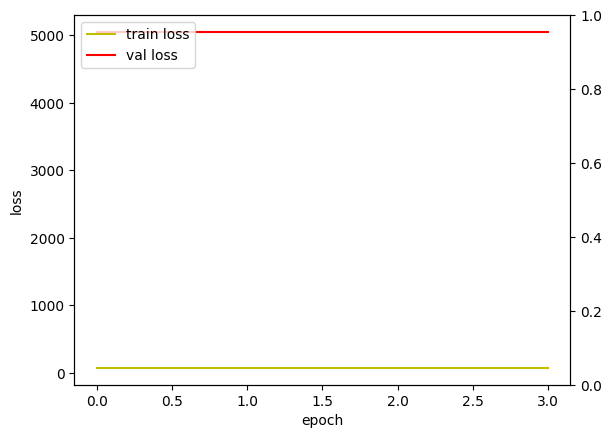

In [66]:
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(tr_losses, 'y', label = 'train loss')
loss_ax.plot(val_losses, 'r', label = 'val loss')

# acc_ax.plot(hist.history['accuracy'], 'b', label = 'train accuracy')
# acc_ax.plot(hist.history['val_accuracy'], 'g', label = 'valid accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
# acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
# acc_ax.legend(loc='lower left')

plt.show()

# 4. Model Test

In [67]:
from sklearn.metrics import accuracy_score

In [68]:
model.eval()
correct_count = 0
with torch.no_grad():
    for batch_idx, samples in enumerate(test_dataloader):
        test_images, test_df, test_labels = samples
        test_images = test_images.to(device)
        test_df = test_df.to(device)
        test_labels = test_labels.to(device)

        y_test_pred = model(test_images, test_df)

        pred = torch.argmax(y_test_pred, dim=1)
        correct_count += accuracy_score(test_labels.cpu(), pred.cpu(), normalize=False) ## normalize : If False, return the number of correctly classified samples. Otherwise, return the fraction of correctly classified samples.

print('accuracy on test set : ', correct_count / len(test_dataset))


accuracy on test set :  0.2753968253968254


0.25712684615286036


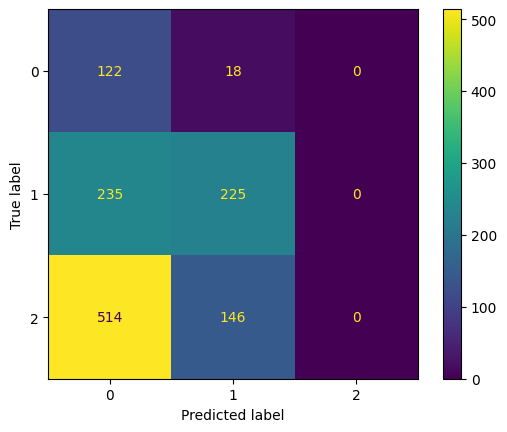

In [69]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
cm = confusion_matrix(test_labels.cpu(), torch.argmax(y_test_pred,1).cpu(), labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2])
disp.plot()

print(f1_score(test_labels.cpu(), torch.argmax(y_test_pred,1).cpu(), average='macro'))